<a href="https://colab.research.google.com/github/lu-ramirez/Clustering-Jerarquico/blob/main/TESIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>MODELOS MATEMÁTICOS DE OPTIMIZACIÓN APLICADOS A LA REUBICACIÓN DE UNA INSTALACIÓN DE ABASTECIMIENTO. Caso de Estudio: CENTRAL DE ABASTECIMIENTO DE LA CIUDAD DE PACHUCA, HIDALGO.<center>

**OBJETIVO:** Desarrollar un sistema integrado de recolección de información e implementación de modelos matemáticos de optimización para obtener soluciones a las diferentes variantes del problema de localización de instalaciones de abastecimiento de perecederos.
## <center><span style="color:black"> Matrices de distancia (viaje de ida y viaje redondo)</span><center>
Esta parte del código busca recopilar la información de la distancia de viaje entre N colonias y colocarla en una matriz desde el origen hasta el destino.

In [1]:
#En esta celda se importan todas las librerías necesarias
import pandas as pd
import numpy as np
#import pybing 
!pip install gurobipy 
import gurobipy        
import time
from gurobipy import *
from math import radians, cos, sin, asin, sqrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.5 MB 4.3 MB/s 


En esta sección del codigo se leen los archivos que continen los datos de entrada al algoritmo 

In [2]:
!pip install -U -q PyDrive  
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth) 

#Archivo de colonias
link = 'https://drive.google.com/file/d/1wkdGhNTnw0J5Rm1YhPrnQi0iYfIPV0fU/view?usp=sharing'
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('Colonias.csv')  

#Archivo de competidores 
link = 'https://drive.google.com/file/d/1xp6vZxrYaJp7rDvU5ykRK0IIU3649O8i/view?usp=sharing'
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('competencia.csv')  

#Archivo de matriz de distancias (Solo es necesario para el caso donde no se corre pybing)
link = 'https://drive.google.com/file/d/199x0YqDnEVAFzDyH7TI0Sg6OiyEDKMK9/view?usp=sharing'
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('matriz.csv')

**La celda siguiente es el codigo para obtener la matriz de distancias de ida **

La salida de la siguiente es un csv con el nombre ("matriz.csv") que más adelante se lee

## <span style="color:RED">TARDA 3 HORAS EN CORRER<span>

In [ ]:
bing = pybing.Bing('AqYMEk50o7HpHlRProGgTyIxdXEhk1SJzvWPdlvJvkSZMKOxPhzg9Lgen7A0-jVH')
data=pd.read_csv("Colonias.csv")  
x=data.to_numpy()                
y=data.to_numpy()
N=len(data)                      
distanceMatrix = [[i for i in range(N)]for j in range(N)] 
for i in range(0,N):     
    time.sleep(100)
    iLat = x[i][0]
    iLon = x[i][1]
    start = (iLat, iLon) 
    for j in range(0,N):
        jLat = y[j][0]
        jLon = y[j][1]
        end= (jLat, jLon)  
        distanceMatrix[i][j]=bing.travelDistance(start,end)
dm=pd.DataFrame(distanceMatrix) #kilometers (one way trip)
dm.to_csv("matriz.csv") 
dm

NameError: ignored

PARA QUE EL CODIGO SIGA SU FLUJO CORRECTAMENTE SE RECOMIENDA CORRER LA SECCIÓN **Matriz de distancia (Geodésica con fórmula haversine)** Y REGRESAR HASTA ESTE PUNTO Y CONTINUAR EJECUTANDO EL CODIGO DE MANERA SECUENCIAL 

$$M=D+ D^T  $$
<center>La matriz de viaje redondo es igual a la matriz del viaje de ida más la matriz transpuesta del viaje de ida <center>

In [5]:
#Matriz de distancias del viaje redondo
dm=pd.read_csv("matriz.csv", sep=",")
#dmt= dm.transpose().to_numpy()
dm=dm.to_numpy() 
distanceMatrix = [[i for i in range(N)]for j in range(N)]
for i in range(0,N):
    for j in range(0,N):
          distanceMatrix[i][j]= dm[i][j]+dm[j][i]
dm_RT=pd.DataFrame(distanceMatrix)
dm_RT.to_csv("matriz_round_trip.csv")



## <center>Matriz de distancia (Geodésica con fórmula haversine) <center>
Esta sección aplica la fórmula haversine para determinar la distancia mínima entre dos puntos en la tierra
#### Formula Haversine :


$$d(A,B)=2\arcsin{\sqrt[2]{\sin^2{\frac{\vartriangle\phi}{2}}+\cos{\phi_s}\cos{\phi_f}\sin^2{\frac{\vartriangle\lambda}{2}}}}$$

$\vartriangle\phi:$  Diferencia entre latitud del primer y segundo punto.

$\vartriangle\lambda:$  Diferencia entre longitud del primer y segundo punto. 

$\phi_s:$ Latitud del primer punto.

$\phi_s:$ Latitud del segundo punto.


In [6]:
def haversine(iLon, iLat, jLon, jLat):
  '''
  Función que obtiene geodesicas con la función de haversine
  Parametros:
  iLon, iLat - Coordenadas del primer punto (Longitud y latitud en decimales)
  jLon, jLat - Coordenadas del segundo punto (Longitud y latitud en decimales)
  Salida: 
  Distancia entre los dos puntos de la tierra
  '''
  lon1, lat1, lon2, lat2 = map(radians, [iLon, iLat, jLon, jLat])
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a)) 
  r = 6371 # Radio de la Tierra en KM.
  return c * r

In [7]:
#Obtención de las geodesicas en km desde las colonias hasta donde se encuentran la competencia.
data=pd.read_csv("Colonias.csv")
data_1=pd.read_csv("competencia.csv")
x=data_1.to_numpy()
y=data.to_numpy()
N=len(data)
G=len(data_1)
distanceMatrix = [[i for i in range(N)]for j in range(G)]
for i in range(0,G):     
    iLat = x[i][0]
    iLon = x[i][1]
    for j in range(0,N):
        jLat = y[j][0]
        jLon = y[j][1] 
        distanceMatrix[i][j]=haversine(iLon, iLat, jLon, jLat)
Dist_haver=pd.DataFrame(distanceMatrix)#kilometros
Dist_haver.to_csv("matriz_distancia_competecia.csv")
Dist_haver

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,5.392288,1.096950,4.616165,3.523447,2.712871,6.489953,2.294504,6.812017,3.382551,2.142465,...,1.271436,1.338510,4.703478,3.944364,3.516057,6.626402,2.009568,1.677996,5.959458,2.716165
1,3.967748,4.969358,8.510256,0.900614,6.353861,4.037530,6.191863,3.811071,4.649587,2.668538,...,4.811815,5.185606,0.897170,3.826768,4.024710,5.799005,5.448197,3.517280,4.372827,4.921961
2,17.526997,11.117886,8.452786,15.317552,11.838644,18.620781,11.031722,18.838004,15.002145,12.650660,...,12.327530,11.688897,16.214393,15.975917,15.444313,12.557995,12.389752,13.728053,18.093222,13.996710
3,5.015759,7.205388,10.725995,2.972688,8.632427,4.298234,8.472272,3.573313,6.633450,4.654219,...,7.094596,7.468070,1.761263,5.541632,5.904391,6.130567,7.720364,5.749152,5.205099,7.069552
4,3.478846,3.871388,6.356638,4.032113,2.983850,5.020030,3.643862,5.753662,0.427745,4.798822,...,2.433260,3.041523,5.179264,1.829658,1.223854,9.479081,2.280594,1.800155,3.958415,0.669688
5,7.135962,6.628305,9.818875,4.125804,8.630245,6.857488,8.147807,6.301238,7.727512,3.819858,...,7.114763,7.255749,3.575221,7.051468,7.189373,3.273023,7.845522,6.265782,7.478104,7.784766
6,5.772297,0.642752,4.047317,4.100787,2.203628,6.948553,1.698101,7.319302,3.490963,2.667799,...,0.966023,0.790656,5.294841,4.241307,3.753758,6.997667,1.630780,1.973563,6.337941,2.680598
7,1.534156,7.024530,10.390141,2.909539,7.401588,0.661103,7.693787,1.014493,4.321613,5.669948,...,6.163082,6.751197,2.709954,2.916808,3.515974,9.132322,6.497907,4.573465,1.502512,5.190307
8,8.174803,5.952955,8.724357,4.968334,8.189804,8.207487,7.522385,7.802508,8.070971,3.444610,...,6.803897,6.774426,4.857405,7.710622,7.696147,1.574800,7.543953,6.373984,8.600628,7.878024
9,11.547547,9.410487,11.711870,8.423507,11.712260,11.305207,10.962179,10.711524,11.713366,7.083016,...,10.395714,10.304976,8.019578,11.275374,11.306534,2.599063,11.128796,10.027911,11.913123,11.530682


## <center>Matriz de alcance  (viaje de ida, viaje redondo y geodésicas)<center>

En esta parte del código las tres matrices de distancias obtenidas en las secciones anteriores se vuelven binarias de acuerdo a un parámetro k de kilómetros como se muestra a continuación siendo $d_{ij}$ la distancia desde i hasta j correspondiente a cada matriz.

$$a_{ij}\begin{cases}1& if\ d_{ij}\leq{k}\\0& if\ d_{ij}> k\end{cases}$$

In [8]:
def alcance (namefile, k, col):
  '''
  Función que obtiene la matriz de alcance que esta definida en la posición i,j 
  por un 1 si la distancia es menor o igual a un paramtro k y 0 en otro caso

  Parametros:
  namefile - Nombre del archivo csv que contiene una matriz de distancia de tamaño NxM
  k - Es el parametro de cobertura  
  Salida: 
  AM- Matriz de alcance
  '''
  
  dm=pd.read_csv(str(namefile), sep=",")
  if col==1:
    del(dm['Unnamed: 0'])
  size=np.shape(dm)
  N=size[0]
  M=size[1]
  dm=dm.to_numpy()
  for i in range(N):     
      for j in range(M):
          if dm[i][j]>k:
            dm[i][j]=0
          else:
            dm[i][j]=1
  AM=pd.DataFrame(dm) 
  return AM 

#Matriz de alcance de ida
#MA_1 = alcance("matriz.csv",7.9,0)
#print(MA_1)
#MA_1.to_csv("matriz_de_ida_prueba.csv")
#Matriz de alcance de viaje redondo
#MA_2=alcance("matriz_round_trip.csv",18,1)
#print(MA_2)
#Matriz de alcance competencia
#MA_3 = alcance("matriz_distancia_competecia.csv",0.2,1)
#print(MA_3)

## <center> Modelos de optimización matemática<center>
### Set Covering Problem ( viaje de ida y viaje redondo)
    


In [9]:
def set_covering(MA):
  '''
  Funcion que resuelve el problema de cobertura de conjuntos dado una matriz de 
  de alcance con restricciones de no apertura
  Parametros:
  MA - Matriz de alcance de tamano N*N
  Salida: 
  Valores de funcion objetivo y variables de decision 
  '''
  N=len(MA)
  #Conjuntos
  sedes=[j for j in range(N)]
  demandante=[i for i in range(N)]
  F =[j for j in range(38)]
  f =[38,39,44,45,47,48,49,51,56,58,59,60,61,62,65,66,67]
  U=F+f
  # Matriz de alcance                 
  a=MA.to_numpy()

  #Modelo
  m1=Model("model_1")

  #Variables
  x=m1.addVars(sedes,vtype=GRB.BINARY, name="x")

  #OFunción objetivo 
  m1.setObjective(quicksum(x[j] for j in sedes), GRB.MINIMIZE)

  #Restricciones
  m1.addConstrs(quicksum(a[i,j]*x[j] for j in demandante)>=1 for i in sedes)
  m1.addConstrs((x[U[u]])==0 for u in range(len(U)))



  m1.display()
  m1.optimize()
  Fo=round(m1.ObjVal, 2)

  print("Funcion objetivo:" , str(round(m1.ObjVal, 2)))     
  for v in m1.getVars():
    if v.X!= 0:
        print (str(v.Varname)+ " = " + str(round(v.X, 2)))  
  return Fo

### Set Covering Problema con restricción de competidores (viaje de ida y viaje redondo)

#### Modelo de viaje de ida con competencia

In [10]:
def set_covering_com(MA,MB):
  '''
  Función que resuelve el problema de cobertura de conjuntos dado una matriz dadas dos matrices de alcance

  Parametros:
  MA - Matriz de alcance de tamaño N*N (Se desea cubrir)
  MB - Matriz de alcance de tamaño M*N (Se desea que no se cubra)
  Salida: 
  Valores de función objetivo y variables de decisión 
  '''
  #Conjuntos 
  sedes=[j for j in range(N)]
  demandante=[i for i in range(N)]
  competencia= [r for r in range(G)]

  F =[j for j in range(38)]
  f =[38,39,44,45,47,48,49,51,56,58,59,60,61,62,65,66,67]
  U=F+f
  
  # MAtriz de alcance de colonias 
  a=MA.to_numpy()
  #Matriz de alcane de competidores
  b=MB.to_numpy()

  #Modelo 
  m3=Model("model_3")

  #Variables
  x=m3.addVars(sedes,vtype=GRB.BINARY, name="x")

  #Función Objetivo
  m3.setObjective(quicksum(x[j] for j in sedes), GRB.MINIMIZE)

  #Restricciones
  m3.addConstrs(quicksum(a[i,j]*x[j] for j in demandante)>=1 for i in sedes)
  m3.addConstrs(quicksum(b[r,j]*x[j] for j in sedes)==0 for r in competencia) 
  m3.addConstrs((x[U[u]])==0 for u in range(len(U)))
     
  m3.display()
  m3.optimize()

  Fo=round(m3.ObjVal, 2)
  print("Función objetivo:" , str(round(m3.ObjVal, 2)))   
     
  for v in m3.getVars():
    if v.X!= 0:
        print (str(v.Varname)+ " = " + str(round(v.X, 2)))  
 
  return Fo

#ANÁLISIS DE SENSIBILIDAD

Minimize
  <gurobi.LinExpr: 0.0>
Subject To
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 123 rows, 68 columns and 2378 nonzeros
Model fingerprint: 0x29be454d
Variable types: 0 continuous, 68 integer (68 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 123 rows and 68 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 3 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Función objetivo: 3.0
x[41] = 1.0
x[42] = 1.0
x[63] = 1.0
Minimize
  <gurobi.LinExpr: 0.0>
Subject To
G

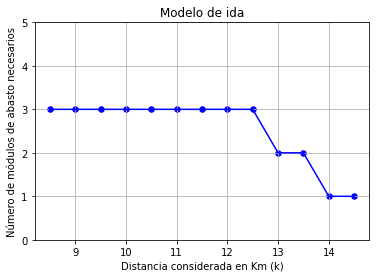

In [23]:
#modelo de ida        
k=np.arange(8.5,15,0.5) #valores de k desde 8.5 hasta 15 con pasos de 0.5
CDs=np.zeros(len(k))    #lista de ceros del tamano de la lista de k
for i in range (len(k)):  #se itera en la cantidad de valores de k (desde o hasta "n=tamano de k")
  FO=set_covering(alcance("matriz.csv",k[i],0))  #obtiene el valor de la función objetivo para la iteracion en curso
  CDs[i]=FO                                     #agrega/sustituye el valor de la funcion objetivo a la lista de 0s
Ansen=pd.DataFrame(CDs)
Ansen.to_csv("Analisis_Sensibilidad_SC_ida.csv")
from matplotlib import pyplot as plt            
plt.scatter(k, CDs, s=30, c="b")    #genera puntitos
#Graficar función
plt.plot(k,CDs,c="b")
#Titulo
plt.title("Modelo de ida")
#Limitar ejes
#plt.xlim(-10,10)
plt.ylim(0,5)
#Mallado
plt.grid()
#Nombres de ejes
plt.xlabel("Distancia considerada en Km (k)")
plt.ylabel("Número de módulos de abasto necesarios")
#Mostrar gráfica
plt.show()

Minimize
  <gurobi.LinExpr: 0.0>
Subject To
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 123 rows, 68 columns and 2349 nonzeros
Model fingerprint: 0x174b3eeb
Variable types: 0 continuous, 68 integer (68 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 123 rows and 68 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Función objetivo: 3.0
x[57] = 1.0
x[63] = 1.0
x[64] = 1.0
Minimize
  <gurobi.LinExpr: 0.0>
Subject To
Gur

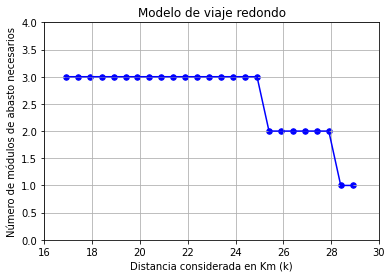

In [24]:
#modelo de viaje redondo   
k=np.arange(16.9,29,0.5) #valores de k desde 16.9 hasta 27 con pasos de 0.5
CDs=np.zeros(len(k))    #lista de ceros del tamaño de la lista de k
for i in range (len(k)):  #se itera en la cantidad de valores de k (desde o hasta "n=tamaño de k")
  FO=set_covering(alcance("matriz_round_trip.csv",k[i],1))  #obtiene el valor de la función objetivo para la iteración en curso
  CDs[i]=FO                                     #agrega/sustituye el valor de la función objetivo a la lista de 0s
Ansen=pd.DataFrame(CDs)
Ansen.to_csv("Analisis_Sensibilidad_SC_viaje redondo.csv")
from matplotlib import pyplot as plt            
plt.scatter(k, CDs, s=30, c="b")    #genera puntitos

#Graficar función
plt.plot(k,CDs,c="b")
#Título
plt.title("Modelo de viaje redondo")
#Limitar ejes
plt.ylim(0,4)
plt.xlim(16,30)
#Mallado
plt.grid()
#Nombres de ejes
plt.xlabel("Distancia considerada en Km (k)")
plt.ylabel("Número de módulos de abasto necesarios")
#Mostrar gráfica
plt.show()

In [13]:
#modelo con competidores y distancias de ida
k  = np.arange(8.5,15,0.5)
kc = np.arange(0.0,1.4,0.1)
CDs=np.zeros((len(k), len(kc)))
for i in range (len(k)):
  for j in range (len(kc)):
    try:
      FO=set_covering_com(alcance("matriz.csv",k[i],0),alcance("matriz_distancia_competecia.csv",kc[j],1))
    except AttributeError:
      CDs[i,j]=0
    else:
      FO=set_covering_com(alcance("matriz.csv",k[i],0),alcance("matriz_distancia_competecia.csv",kc[j],1))
      CDs[i,j]=FO
Ansen=pd.DataFrame(CDs)
Ansen.to_csv("Analisis_Sensibilidad_SCC_ida.csv")
print(CDs)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Función objetivo: 3.0
x[40] = 1.0
x[54] = 1.0
x[64] = 1.0
Minimize
  <gurobi.LinExpr: 0.0>
Subject To
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 154 rows, 68 columns and 3371 nonzeros
Model fingerprint: 0xbf5658a0
Variable types: 0 continuous, 68 integer (68 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 154 rows and 68 columns
Presolve time: 0.00s
Presolve: All rows a

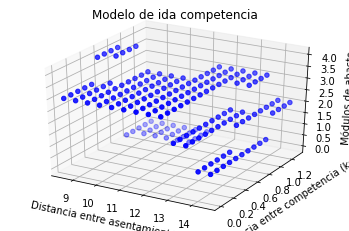

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
tam=len(k)*len(kc)
puntos=np.zeros((tam,3))
r=0
for i in range (len(k)):
  for j in range (len(kc)):
      puntos[r,0]=k[i] 
      puntos[r,1]=kc[j]
      puntos[r,2]=CDs[i,j]
      r = r+1
figura = plt.figure()
grafica = figura.add_subplot(111,projection = '3d')
[xi, yi , zi] = np.transpose(puntos)
grafica.scatter(xi,yi,zi,
                c = 'blue',
                marker='o',
                label = 'puntos[i]')
grafica.set_title('Modelo de ida competencia')
grafica.set_xlabel('Distancia entre asentamientos (k)')
grafica.set_ylabel('Distancia entre competencia (kc)')
grafica.set_zlabel('Módulos de abasto')
#grafica.legend()
plt.show()

In [33]:
#modelo con competidores y distancias de viaje redondo
k  = np.arange(16.9,28,1)
kc = np.arange(0,1.4,0.1)
CDs=np.zeros((len(k), len(kc)))
for i in range (len(k)):
  for j in range (len(kc)):
    print(k[i],kc[j])
    try:
      FO=set_covering_com(alcance("matriz_round_trip.csv",k[i],1),alcance("matriz_distancia_competecia.csv",kc[j],1))
    except AttributeError:
      CDs[i,j]=0
    else:
      FO=set_covering_com(alcance("matriz_round_trip.csv",k[i],1),alcance("matriz_distancia_competecia.csv",kc[j],1))
      CDs[i,j]=FO
Ansen=pd.DataFrame(CDs)
Ansen.to_csv("Analisis_Sensibilidad_SCC_viajeredondo.csv")
print(CDs)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Función objetivo: 3.0
x[46] = 1.0
x[54] = 1.0
x[64] = 1.0
Minimize
  <gurobi.LinExpr: 0.0>
Subject To
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 154 rows, 68 columns and 3198 nonzeros
Model fingerprint: 0x07161186
Variable types: 0 continuous, 68 integer (68 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 154 rows and 68 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.0000000000

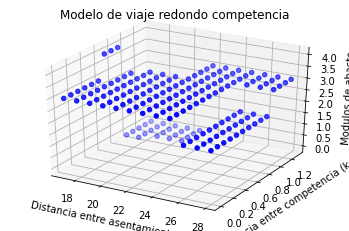

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
tam=len(k)*len(kc)
puntos=np.zeros((tam,3))
r=0
for i in range (len(k)):
  for j in range (len(kc)):
      puntos[r,0]=k[i] 
      puntos[r,1]=kc[j]
      puntos[r,2]=CDs[i,j]
      r = r+1
figura = plt.figure()
grafica = figura.add_subplot(111,projection = '3d')
[xi, yi , zi] = np.transpose(puntos)
grafica.scatter(xi,yi,zi,
                c = 'blue',
                marker='o',
                label = 'puntos[i]')
#sup = grafica.plot_surface(X, Y,CDs , cmap="jet")
grafica.set_title('Modelo de viaje redondo competencia')
grafica.set_xlabel('Distancia entre asentamientos (k)')
grafica.set_ylabel('Distancia entre competencia (kc)')
grafica.set_zlabel('Modulos de abasto')
#grafica.legend()
plt.show()

[16.9 17.9 18.9 19.9 20.9 21.9 22.9 23.9 24.9 25.9 26.9 27.9] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3]
      0    1    2    3    4    5    6    7    8    9   10   11   12   13
0   3.0  3.0  3.0  3.0  3.0  3.0  4.0  4.0  4.0  0.0  0.0  0.0  0.0  0.0
1   3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  0.0  0.0  0.0  0.0  0.0
2   3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  0.0  0.0  0.0  0.0
3   3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  0.0  0.0  0.0  0.0
4   3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  0.0  0.0  0.0  0.0
5   3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
6   3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
7   3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
8   3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
9   2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  3.0  3.0  3.0  3.0
10  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  3.0  3.0  3.0  3.0
11  

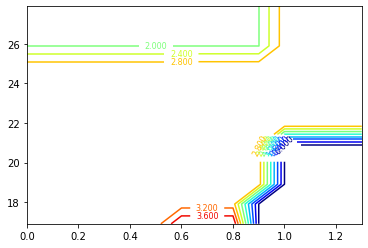

In [42]:
#Importamos librerías
import numpy as np
from matplotlib import pyplot as plt
 
matriz= pd.read_csv("Analisis_Sensibilidad_SCC_viajeredondo.csv")
matriz.to_numpy()
del(matriz['Unnamed: 0'])
print(k,kc)
print(matriz)

#Asignar valores a x y y
x = kc
y = k

#Generamos mallado y obtenemos z
X, Y = np.meshgrid(x,y)
Z = matriz

#Definir figura
contornos = plt.contour(X,Y,Z,levels=12, cmap="jet")

#Señalar niveles
plt.clabel(contornos, fontsize=8)
plt.show()